# 사용 패키지

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [46]:
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import argparse
import easydict
from torch import autograd

In [47]:
from torch.utils import data
from torchvision import datasets, transforms
import os

# 데이터 로드

In [70]:
total = pd.read_csv('./data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')

In [71]:
total.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


In [72]:
print(total.shape)

(368088, 4)


In [73]:
total.isnull().sum()

연월일    0
시간     0
구분     0
공급량    0
dtype: int64

# 전처리

In [74]:
total['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [75]:
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map) # 이 과정은 A~H 까지의 알파벳을 숫자로 매핑(대치)시키는 과정

In [76]:
total['구분']

0         0
1         0
2         0
3         0
4         0
         ..
368083    6
368084    6
368085    6
368086    6
368087    6
Name: 구분, Length: 368088, dtype: int64

In [77]:
d_map

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'G': 5, 'H': 6}

In [78]:
total['연월일'] = pd.to_datetime(total['연월일']) # 시계열 데이터로

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "/USER/d2coding.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

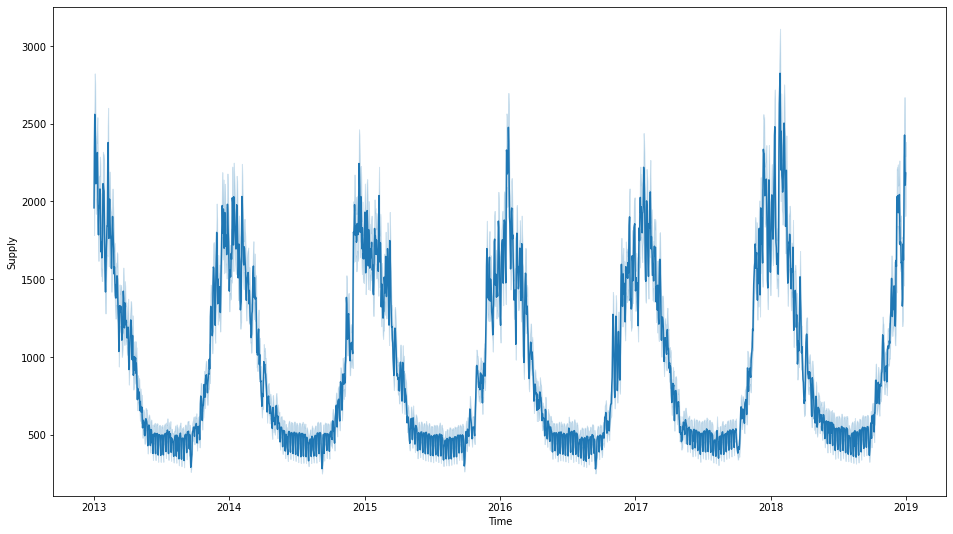

In [58]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=total['공급량'], x=total['연월일'])
plt.xlabel('Time')
plt.ylabel('Supply')
plt.show()

In [ ]:
# 이를 통해 매 겨울 시기에 공급량이 많았다는 것을 알 수 있다. 

In [80]:
total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

In [81]:
total

,연월일,시간,구분,공급량,year,month,day,weekday
0,2013-01-01,1,0,2497.129,2013,1,1,1
1,2013-01-01,2,0,2363.265,2013,1,1,1
2,2013-01-01,3,0,2258.505,2013,1,1,1
3,2013-01-01,4,0,2243.969,2013,1,1,1
4,2013-01-01,5,0,2344.105,2013,1,1,1
...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,6,681.033,2018,12,31,0
368084,2018-12-31,21,6,669.961,2018,12,31,0
368085,2018-12-31,22,6,657.941,2018,12,31,0
368086,2018-12-31,23,6,610.953,2018,12,31,0


In [90]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [83]:
# 연속형 변수인 공급량 컬럼은 따로 drop 하자
scale_cols = ['공급량']
cont_var = total[scale_cols]
# total.drop(columns=['공급량'], inplace=True)
etc = total.drop(columns=['공급량'])
print(cont_var)
print(etc)

             공급량
0       2497.129
1       2363.265
2       2258.505
3       2243.969
4       2344.105
...          ...
368083   681.033
368084   669.961
368085   657.941
368086   610.953
368087   560.896

[368088 rows x 1 columns]
              연월일  시간  구분  year  month  day  weekday
0      2013-01-01   1   0  2013      1    1        1
1      2013-01-01   2   0  2013      1    1        1
2      2013-01-01   3   0  2013      1    1        1
3      2013-01-01   4   0  2013      1    1        1
4      2013-01-01   5   0  2013      1    1        1
...           ...  ..  ..   ...    ...  ...      ...
368083 2018-12-31  20   6  2018     12   31        0
368084 2018-12-31  21   6  2018     12   31        0
368085 2018-12-31  22   6  2018     12   31        0
368086 2018-12-31  23   6  2018     12   31        0
368087 2018-12-31  24   6  2018     12   31        0

[368088 rows x 7 columns]


In [84]:
# 데이터 정규화: continuous variable
from sklearn.preprocessing import MinMaxScaler

cont_var.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(cont_var)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,공급량
0,0.215295
1,0.203747
2,0.194710
3,0.193456
4,0.202094
...,...
368083,0.058630
368084,0.057675
368085,0.056638
368086,0.052585


In [85]:
total = pd.concat([etc,df_scaled], axis=1)
total

,연월일,시간,구분,year,month,day,weekday,공급량
0,2013-01-01,1,0,2013,1,1,1,0.215295
1,2013-01-01,2,0,2013,1,1,1,0.203747
2,2013-01-01,3,0,2013,1,1,1,0.194710
3,2013-01-01,4,0,2013,1,1,1,0.193456
4,2013-01-01,5,0,2013,1,1,1,0.202094
...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,6,2018,12,31,0,0.058630
368084,2018-12-31,21,6,2018,12,31,0,0.057675
368085,2018-12-31,22,6,2018,12,31,0,0.056638
368086,2018-12-31,23,6,2018,12,31,0,0.052585


In [86]:
# train_years = [2013,2014,2015,2016,2017]
# val_years = [2018]

In [65]:
# train = total[total['year'].isin(train_years)]
# val = total[total['year'].isin(val_years)]
# train = total[total['연월일'].dt.year.isin(train_years)]
# val = total[total['연월일'].dt.year.isin(val_years)]

In [27]:
# train.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,0,0.215295
1,2013-01-01,2,0,0.203747
2,2013-01-01,3,0,0.194710
3,2013-01-01,4,0,0.193456
4,2013-01-01,5,0,0.202094


In [66]:
val

,연월일,시간,구분,공급량
306768,2018-01-01,1,0,0.152139
306769,2018-01-01,2,0,0.144735
306770,2018-01-01,3,0,0.138843
306771,2018-01-01,4,0,0.138260
306772,2018-01-01,5,0,0.147524
...,...,...,...,...
368083,2018-12-31,20,6,0.058630
368084,2018-12-31,21,6,0.057675
368085,2018-12-31,22,6,0.056638
368086,2018-12-31,23,6,0.052585


In [99]:
features = ['구분', 'month', 'day', 'weekday', '시간']
# features = ['구분', '연월일', '시간']
label = ['공급량']
# train_x = train[features]
# train_y = train[['공급량']]
train_x = total[features]
train_y = total[label]

# train dataset
train_x, train_y = make_dataset(train_x, train_y, 30)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_x, test_size=0.2)

x_train.shape, x_valid.shape

((294446, 30, 5), (73612, 30, 5))

In [100]:
y_train.shape, y_valid.shape

((294446, 30, 5), (73612, 30, 5))

# 학습

In [30]:
# d_train = lgb.Dataset(train_x, train_y)
# d_val = lgb.Dataset(val_x, val_y)

# params = {
#     'objective': 'regression',
#     'metric':'mae',
#     'seed':42
# }

# model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, early_stopping_rounds=50)

In [127]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(x_train.shape[1], x_train.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(30))
model.add(Dense(5))

In [128]:
import os

model.compile(loss='mean_absolute_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=300, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/300


InvalidArgumentError:  Incompatible shapes: [16,5] vs. [16,30,5]
	 [[node gradient_tape/mean_absolute_error/sub/BroadcastGradientArgs (defined at tmp/ipykernel_140613/3689821663.py:10) ]] [Op:__inference_train_function_16676]

Function call stack:
train_function


# 추론 및 결과 제출

In [87]:
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [88]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [89]:
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [ ]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [ ]:
test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday

In [ ]:
test['구분'] = test['구분'].map(d_map)

In [ ]:
test_x = test[features]

In [ ]:
test_x

In [ ]:
preds = model.predict(test_x)

In [ ]:
submission['공급량'] = preds

In [ ]:
submission.to_csv('baseline.csv', index=False)